In [1]:
import gc
!nvidia-smi

Tue Aug  9 15:02:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| 61%   46C    P8     9W / 184W |    565MiB / 12288MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist,cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [3]:
BIT_COUNT = 16
FREQ_LIMIT = 20

In [4]:
def rgb2gray(rgb):
    if len(rgb.shape)==3:
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    else:
        r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]


    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

#  Load data

In [5]:
(x_train, y_train), (x_test, y_test) =  cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = rgb2gray(x_train)
x_train = np.expand_dims(x_train, axis=-1)
x_test = rgb2gray(x_test)
x_test = np.expand_dims(x_test, axis=-1)

x_train = x_train[:1500]

y_train = y_train[:1500]
x_test = x_test[:1500]

x_train = tf.image.resize(x_train, [28,28]).numpy()
x_test = tf.image.resize(x_test, [28,28]).numpy()

num_classes = 10
image_shape = (28, 28, 1)
x_train = x_train.reshape((-1,) + image_shape)
x_test = x_test.reshape((-1,) + image_shape)

# x_train =  np.concatenate((x_train[:,:14, :14, :] , x_train[:,:14, 14:, :] , x_train[:,14:, :14, :] , x_train[:,14:, 14:, :]))
# x_test =  np.concatenate((x_test[:,:14, :14, :] , x_test[:,:14, 14:, :] , x_test[:,14:, :14, :] , x_test[:,14:, 14:, :]))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# PGD

In [6]:
iterations = 7  #攻擊次數
alpha = 0.0001  #攻擊程度
epsilon = 8.0 / 255  #攻擊範圍


#loss_object = tf.keras.losses.BinaryCrossentropy()  #我們選擇的loss function


#利用pgd的idea修改圖片 讓它生出我想要的label
def pgd_attack_to_target(input_image, target_label, loss_object, model, epsilon, alpha, iterations):
    x_adv = input_image  # 複製一個圖片 (不要動到原圖片)
    for i in range(iterations):  # 做很多次
        x_adv = tf.convert_to_tensor(x_adv)  # 將圖片轉成tensor
        with tf.GradientTape() as tape:  #開始計算梯度
            tape.watch(x_adv)  # 要計算的圖片是x_adv
            prediction = model(x_adv)  #先做判斷(取得目前的結果)
            loss = loss_object(target_label, prediction)  # 計算loss(距離target有多遠)
        grad = tape.gradient(loss, x_adv)  # 計算梯度 (loss對x_adv的梯度，d_loss/d_x_adv)
        x_adv_new = x_adv - alpha * tf.sign(grad)  # 更新圖片(做梯度下降會讓預測結果接近我想要的label)
        x_adv = tf.clip_by_value(x_adv_new, x_adv - epsilon, x_adv + epsilon)  # 限制圖片的範圍
        x_adv = tf.clip_by_value(x_adv, 0, 1)  # 限制圖片的範圍(圖片要在0~1之間)
        x_adv = x_adv.numpy()  # 將圖片轉成numpy
    return x_adv  # 回傳攻擊後的圖片

# Label

In [7]:
list = np.array([ i for i in range(BIT_COUNT+1)])
user_code = np.eye(BIT_COUNT+1)[list]
print(user_code)  #生成onehot encoding

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# low pass

In [8]:
def low_pass(fshift_origin, freq):
    fshift = fshift_origin.copy()
    cy, cx = fshift.shape[0]//2,fshift.shape[1]//2  #常跟寬的一半是中心點
    h = np.arange(fshift.shape[0]).reshape((-1,1)) - cy
    w = np.arange(fshift.shape[1]).reshape((1,-1)) - cx
    freq = freq**2
    fshift = np.where(h**2+w**2<=freq,fshift,0)
    return fshift
    #上面這四行等於下面這幾行註解
#    for y in range(fshift.shape[0]):
#        dy = (y - cy)**2
#        for x in range(fshift.shape[1]):
#            dx = (x-cx)**2
#            if dx+dy > freq:     ＃大於這個範圍(圓)的設為零（為了方便省略開根號）
#                fshift[y, x] = 0
#     ifft_f = np.fft.ifft2(np.fft.fftshift(fshift))
#     return np.abs(ifft_f)  #回傳挖洞後的頻率圖

def get_low_pass_image(img_original, freq):
    f_img = np.fft.fft2(img_original) # cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT) # produce a two-channel image
    fshift_img = np.fft.fftshift(f_img)
    ifft_f = np.fft.ifft2(np.fft.fftshift(low_pass(fshift_img,freq)))
    return np.abs(ifft_f)

def batch_low_pass_image(img_batch, freq):
    result_img = np.zeros_like(img_batch)
    for i in range(img_batch.shape[0]):
        f_img = np.fft.fft2(img_batch[i,:,:,0]) # cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT) # produce a two-channel image
        fshift_img = np.fft.fftshift(f_img)
        ifft_f = np.fft.ifft2(np.fft.fftshift(low_pass(fshift_img,freq)))
        result_img[i,:,:,0] = np.abs(ifft_f)
    return result_img


# 原始模型

In [9]:
original_decoder = tf.keras.models.load_model('models/decoder_one_hot_4_bit_cifar_10_binary_crossentropy.h5')
acc_list_original = []

x_test_adv = [x_test.copy() for i in range(BIT_COUNT+1)]
for epoch in range(20):
        print("epoch:",epoch+1)
        for i in range(1, BIT_COUNT+1):
            x_test_adv[i] = pgd_attack_to_target(x_test_adv[i], [user_code[i]] * len(x_test),
                                                 tf.keras.losses.CategoricalCrossentropy(), original_decoder, epsilon, alpha,
                                                 iterations)

for freq_inverse in range(0,FREQ_LIMIT,1):
    print("freq:",FREQ_LIMIT-freq_inverse)
    test_acc_list = []
    for i in range(BIT_COUNT+1):
        result = original_decoder.evaluate(batch_low_pass_image(x_test_adv[i],FREQ_LIMIT-freq_inverse), np.array([user_code[i]] * len(x_test)))
        test_acc_list.append(result[1])
    #print("accuracy:",np.mean(test_acc_list),"±",np.std(test_acc_list))
    acc_list_original.append(np.mean(test_acc_list))
del x_test_adv
gc.collect()

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
freq: 20
47/47 [==============================] - 0s 7ms/step - loss: 3.0991e-08 - categorical_accuracy: 1.0000
freq: 19
47/47 [==============================] - 0s 4ms/step - loss: 2.0645e-06 - categorical_accuracy: 1.0000
freq: 18
47/47 [==============================] - 0s 4ms/step - loss: 3.6342e-05 - categorical_accuracy: 1.0000
freq: 17
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - categorical_accuracy: 0.9953
freq: 16
47/47 [==============================] - 0s 5ms/step - loss: 0.0097 - categorical_accuracy: 0.9740
freq: 15
47/47 [==============================] - 0s 7ms/step - loss: 0.0449 - categorical_accuracy: 0.8767
freq: 14
47/47 [==============================] - 0s 4ms/step - loss: 0.1760 - categorical_accuracy: 0.5147
freq: 13
47/47 [=========================

42470

# low pass filter 8

In [12]:
low_pass_8_decoder = tf.keras.models.load_model('models/decoder_low_pass_cifar_adversarial_8.h5')
acc_list_low_pass_8 = []

x_test_adv = [x_test.copy() for i in range(BIT_COUNT+1)]
for epoch in range(20):
    print("epoch:",epoch+1)
    for i in range(1, BIT_COUNT+1):

        x_test_adv[i] = pgd_attack_to_target(x_test_adv[i], [user_code[i]] * len(x_test),
                                             tf.keras.losses.CategoricalCrossentropy(), low_pass_8_decoder, epsilon, alpha,
                                             iterations)

for freq_inverse in range(0,FREQ_LIMIT,1):
    print("freq:",FREQ_LIMIT-freq_inverse)
    test_acc_list = []
    for i in range(BIT_COUNT+1):
        result = low_pass_8_decoder.evaluate(batch_low_pass_image(x_test_adv[i],FREQ_LIMIT-freq_inverse), np.array([user_code[i]] * len(x_test)))
        test_acc_list.append(result[1])
    #print("accuracy:",np.mean(test_acc_list),"±",np.std(test_acc_list))
    acc_list_low_pass_8.append(np.mean(test_acc_list))
del x_test_adv
gc.collect()

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
freq: 20
47/47 [==============================] - 0s 4ms/step - loss: 0.0055 - categorical_accuracy: 0.9907
freq: 19
47/47 [==============================] - 0s 4ms/step - loss: 0.0055 - categorical_accuracy: 0.9900
freq: 18
47/47 [==============================] - 0s 6ms/step - loss: 0.0056 - categorical_accuracy: 0.9907
freq: 17
47/47 [==============================] - 0s 5ms/step - loss: 0.0057 - categorical_accuracy: 0.9900
freq: 16
47/47 [==============================] - 0s 5ms/step - loss: 0.0058 - categorical_accuracy: 0.9907
freq: 15
47/47 [==============================] - 0s 4ms/step - loss: 0.0061 - categorical_accuracy: 0.9887
freq: 14
47/47 [==============================] - 0s 7ms/step - loss: 0.0072 - categorical_accuracy: 0.9860
freq: 13
47/47 [==============================] - 0s 

43356

# plot result

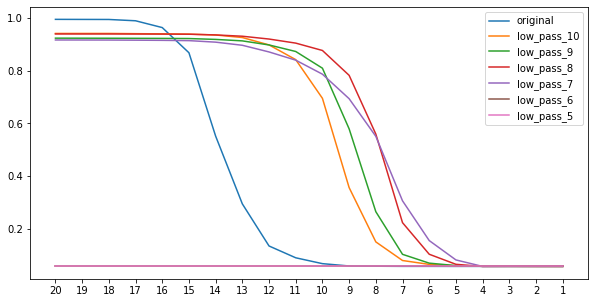

In [16]:

#plot result
plt.figure(figsize=(10,5))
x_label = [str(i) for i in range(FREQ_LIMIT,0,-1)]
plt.plot(x_label,acc_list_original, label='original')
plt.plot(x_label,acc_list_low_pass_8, label='low_pass_8')
plt.legend()
plt.show()